In [3]:
import h5py
import numpy as np
import jax.numpy as jnp
import jax_cfd.base.grids as grids
import matplotlib.pyplot as plt
import os
from jax import vmap

#Load the saved Matlab-Data
def load_s(mat_file_path: str) -> np.ndarray:
    def _find_s(group: h5py.Group):
        # direct hit at this level?
        if 's' in group:
            item = group['s']
            if isinstance(item, h5py.Dataset):
                return np.array(item)
            # if 's' is a group, try to find a dataset inside it
            if isinstance(item, h5py.Group):
                # grab first dataset within this group
                for _, sub in item.items():
                    if isinstance(sub, h5py.Dataset):
                        return np.array(sub)
        # otherwise search recursively
        for _, item in group.items():
            if isinstance(item, h5py.Group):
                out = _find_s(item)
                if out is not None:
                    return out
        return None

    with h5py.File(mat_file_path, 'r') as f:
        s = _find_s(f)
        if s is None:
            raise KeyError("Variable 's' not found in the .mat file.")
        return s

#Calculate the vorticity from DNS and LES data based on grid    
def spectral_vorticity(U: jnp.ndarray,V: jnp.ndarray,grid) -> jnp.ndarray:
    kx, ky = grid.rfft_mesh()
    U_hat = jnp.fft.rfft2(U, axes=(0,1))
    V_hat = jnp.fft.rfft2(V, axes=(0,1))
    w_hat = 1j * ( kx * V_hat - ky * U_hat )
    w = jnp.fft.irfft2(w_hat, s=U.shape, axes=(0,1))
    return w

#Filter and Downsample DNS data
def down_rez(x: jnp.ndarray, Nx: int, Ny: int) -> jnp.ndarray:
    Mx, My = x.shape
    assert Nx <= Mx and Ny <= My, "Output resolution must be <= input resolution"
    assert Mx % 2 == 0 and My % 2 == 0 and Nx % 2 == 0 and Ny % 2 == 0, "Only even dimensions supported"

    kx = jnp.fft.fftfreq(Nx, 1.0/Nx)[:, None]
    ky = jnp.fft.rfftfreq(Ny, 1.0/Ny)[None, :]
    k_mag = jnp.sqrt(kx**2 + ky**2)
    Delta = 6 * jnp.pi / Nx
    G = jnp.exp(-(k_mag**2) * (Delta**2) / 24.0)

    x_hat = jnp.fft.rfft2(x)  
    x_hat_trunc = jnp.zeros((Nx, Ny // 2 + 1), dtype=jnp.complex128)
    x_hat_trunc = x_hat_trunc.at[:Nx // 2, :].set(x_hat[:Nx // 2, :Ny // 2 + 1])
    x_hat_trunc = x_hat_trunc.at[-Nx // 2:, :].set(x_hat[-Nx // 2:, :Ny // 2 + 1])

    factor = (Nx * Ny) / (Mx * My)
    x_downsampled = jnp.fft.irfft2(x_hat_trunc * G, s=(Nx, Ny)) * factor

    return x_downsampled

def correlation(a,b):
    dot = lambda A, B: jnp.real(jnp.vdot(A, B))   
    num = dot(a, b)                                     
    den = jnp.maximum(dot(a, a), dot(b, b))           
    #den = dot(dRdt, dRdt)
    err = num / (den + 1e-30)
    return err

[1/12] Computing correlations and saving TXT...


/tmp/ipykernel_3086830/2037543932.py:59: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  x_hat_trunc = jnp.zeros((Nx, Ny // 2 + 1), dtype=jnp.complex128)


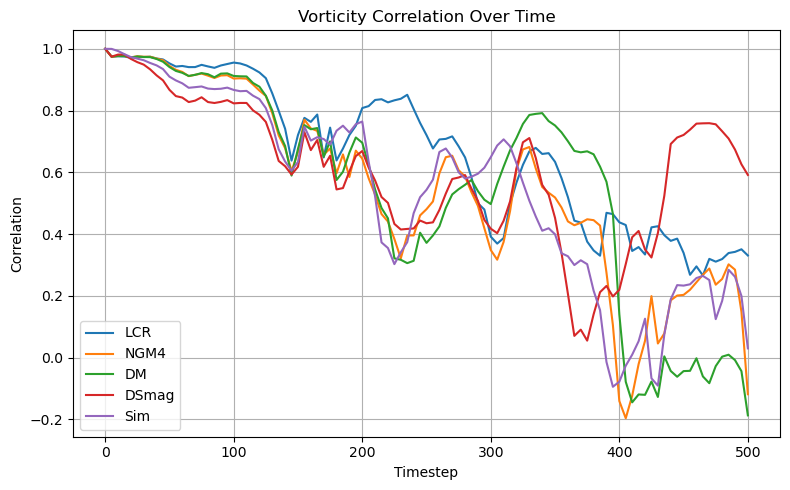

  • saved /storage/home/hcoda1/4/mugliotti3/scratch/Correlations/MatureVM_1e-7/AUX_1_Model_Test.txt
  • saved /storage/home/hcoda1/4/mugliotti3/scratch/Correlations/MatureVM_1e-7/AUX_1_NGM4_Test.txt
  • saved /storage/home/hcoda1/4/mugliotti3/scratch/Correlations/MatureVM_1e-7/AUX_1_DSmag_Test.txt
  • saved /storage/home/hcoda1/4/mugliotti3/scratch/Correlations/MatureVM_1e-7/AUX_1_Sim_Test.txt
  • saved /storage/home/hcoda1/4/mugliotti3/scratch/Correlations/MatureVM_1e-7/AUX_1_DM_Test.txt
[2/12] Computing correlations and saving TXT...


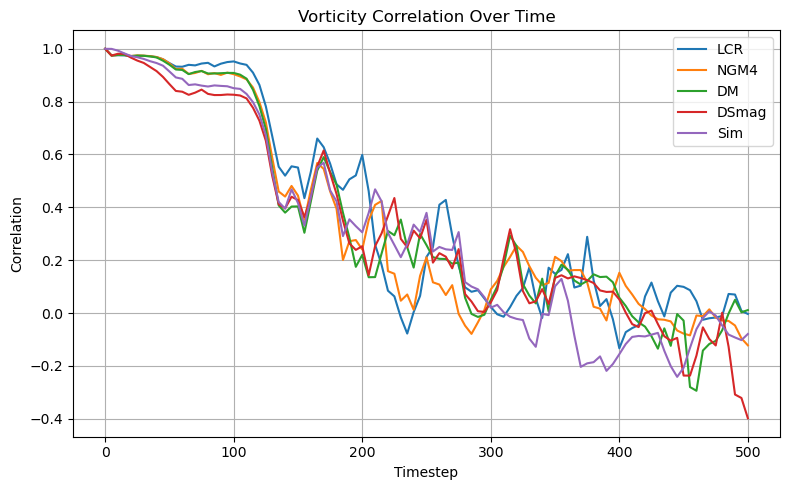

  • saved /storage/home/hcoda1/4/mugliotti3/scratch/Correlations/MatureVM_1e-7/AUX_2_Model_Test.txt
  • saved /storage/home/hcoda1/4/mugliotti3/scratch/Correlations/MatureVM_1e-7/AUX_2_NGM4_Test.txt
  • saved /storage/home/hcoda1/4/mugliotti3/scratch/Correlations/MatureVM_1e-7/AUX_2_DSmag_Test.txt
  • saved /storage/home/hcoda1/4/mugliotti3/scratch/Correlations/MatureVM_1e-7/AUX_2_Sim_Test.txt
  • saved /storage/home/hcoda1/4/mugliotti3/scratch/Correlations/MatureVM_1e-7/AUX_2_DM_Test.txt
[3/12] Computing correlations and saving TXT...


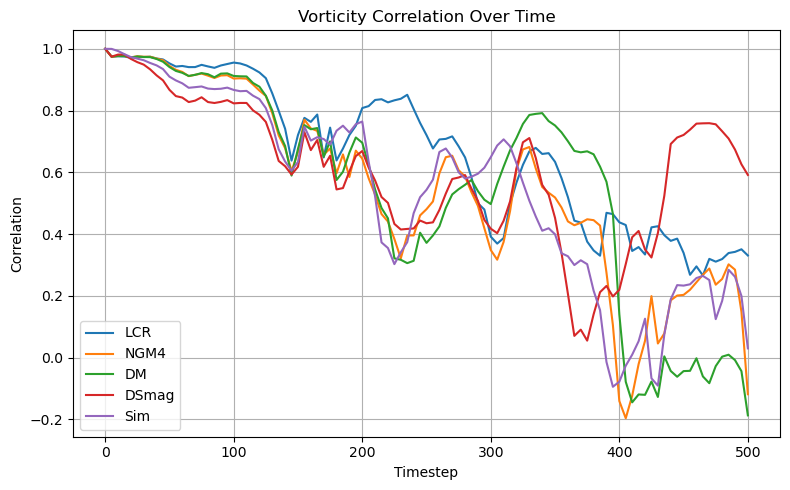

  • saved /storage/home/hcoda1/4/mugliotti3/scratch/Correlations/MatureVM_1e-7/AUX_3_Model_Test.txt
  • saved /storage/home/hcoda1/4/mugliotti3/scratch/Correlations/MatureVM_1e-7/AUX_3_NGM4_Test.txt
  • saved /storage/home/hcoda1/4/mugliotti3/scratch/Correlations/MatureVM_1e-7/AUX_3_DSmag_Test.txt
  • saved /storage/home/hcoda1/4/mugliotti3/scratch/Correlations/MatureVM_1e-7/AUX_3_Sim_Test.txt
  • saved /storage/home/hcoda1/4/mugliotti3/scratch/Correlations/MatureVM_1e-7/AUX_3_DM_Test.txt
[4/12] Computing correlations and saving TXT...


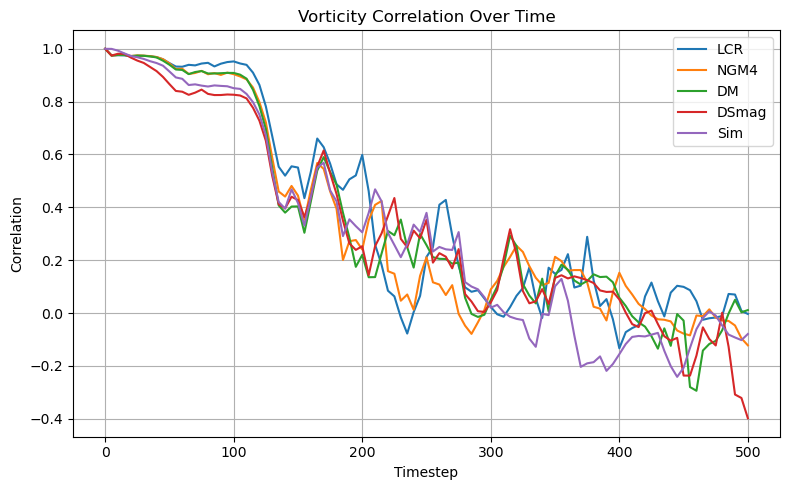

  • saved /storage/home/hcoda1/4/mugliotti3/scratch/Correlations/MatureVM_1e-7/AUX_4_Model_Test.txt
  • saved /storage/home/hcoda1/4/mugliotti3/scratch/Correlations/MatureVM_1e-7/AUX_4_NGM4_Test.txt
  • saved /storage/home/hcoda1/4/mugliotti3/scratch/Correlations/MatureVM_1e-7/AUX_4_DSmag_Test.txt
  • saved /storage/home/hcoda1/4/mugliotti3/scratch/Correlations/MatureVM_1e-7/AUX_4_Sim_Test.txt
  • saved /storage/home/hcoda1/4/mugliotti3/scratch/Correlations/MatureVM_1e-7/AUX_4_DM_Test.txt
[5/12] Computing correlations and saving TXT...


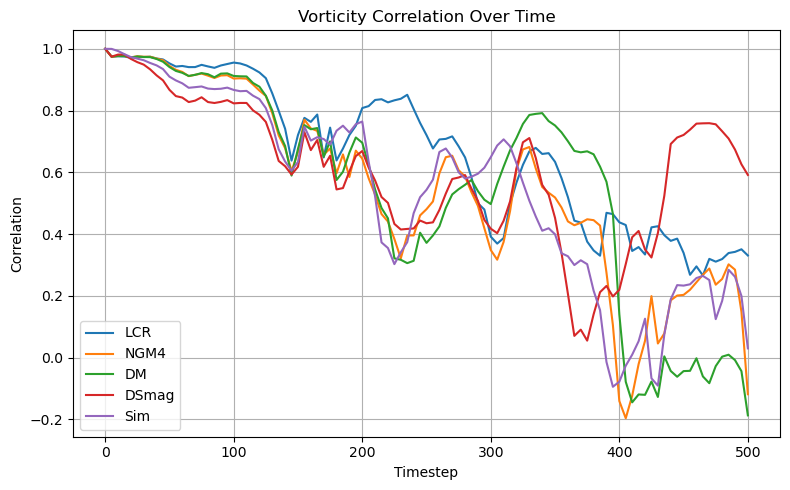

  • saved /storage/home/hcoda1/4/mugliotti3/scratch/Correlations/MatureVM_1e-7/AUX_5_Model_Test.txt
  • saved /storage/home/hcoda1/4/mugliotti3/scratch/Correlations/MatureVM_1e-7/AUX_5_NGM4_Test.txt
  • saved /storage/home/hcoda1/4/mugliotti3/scratch/Correlations/MatureVM_1e-7/AUX_5_DSmag_Test.txt
  • saved /storage/home/hcoda1/4/mugliotti3/scratch/Correlations/MatureVM_1e-7/AUX_5_Sim_Test.txt
  • saved /storage/home/hcoda1/4/mugliotti3/scratch/Correlations/MatureVM_1e-7/AUX_5_DM_Test.txt
[6/12] Computing correlations and saving TXT...


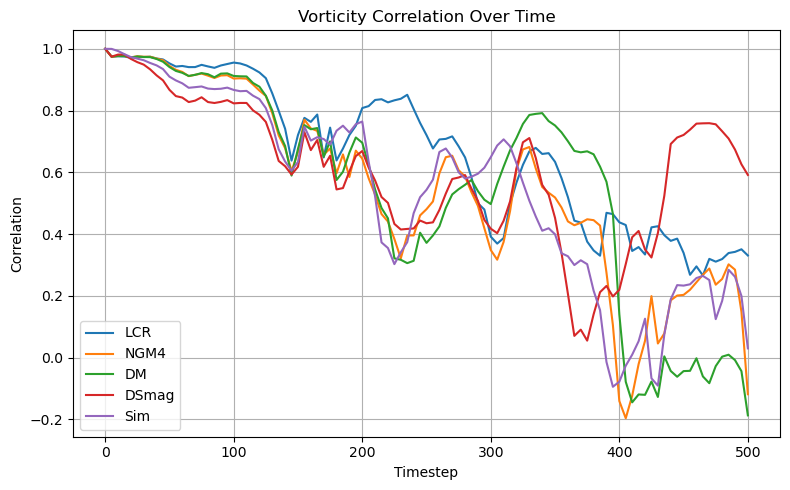

  • saved /storage/home/hcoda1/4/mugliotti3/scratch/Correlations/MatureVM_1e-7/AUX_6_Model_Test.txt
  • saved /storage/home/hcoda1/4/mugliotti3/scratch/Correlations/MatureVM_1e-7/AUX_6_NGM4_Test.txt
  • saved /storage/home/hcoda1/4/mugliotti3/scratch/Correlations/MatureVM_1e-7/AUX_6_DSmag_Test.txt
  • saved /storage/home/hcoda1/4/mugliotti3/scratch/Correlations/MatureVM_1e-7/AUX_6_Sim_Test.txt
  • saved /storage/home/hcoda1/4/mugliotti3/scratch/Correlations/MatureVM_1e-7/AUX_6_DM_Test.txt
[7/12] Computing correlations and saving TXT...


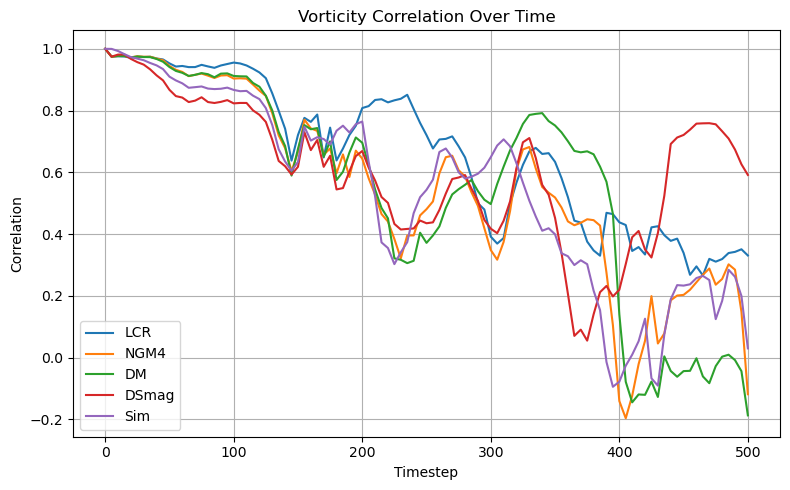

  • saved /storage/home/hcoda1/4/mugliotti3/scratch/Correlations/MatureVM_1e-7/AUX_7_Model_Test.txt
  • saved /storage/home/hcoda1/4/mugliotti3/scratch/Correlations/MatureVM_1e-7/AUX_7_NGM4_Test.txt
  • saved /storage/home/hcoda1/4/mugliotti3/scratch/Correlations/MatureVM_1e-7/AUX_7_DSmag_Test.txt
  • saved /storage/home/hcoda1/4/mugliotti3/scratch/Correlations/MatureVM_1e-7/AUX_7_Sim_Test.txt
  • saved /storage/home/hcoda1/4/mugliotti3/scratch/Correlations/MatureVM_1e-7/AUX_7_DM_Test.txt
[8/12] Computing correlations and saving TXT...


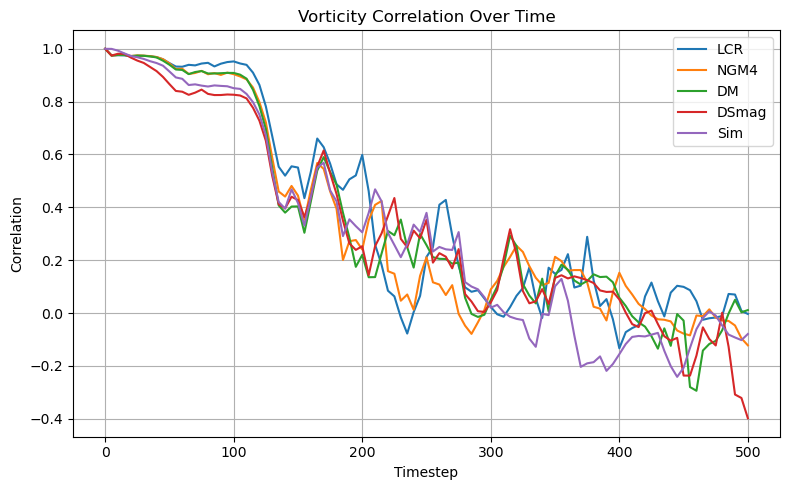

  • saved /storage/home/hcoda1/4/mugliotti3/scratch/Correlations/MatureVM_1e-7/AUX_8_Model_Test.txt
  • saved /storage/home/hcoda1/4/mugliotti3/scratch/Correlations/MatureVM_1e-7/AUX_8_NGM4_Test.txt
  • saved /storage/home/hcoda1/4/mugliotti3/scratch/Correlations/MatureVM_1e-7/AUX_8_DSmag_Test.txt
  • saved /storage/home/hcoda1/4/mugliotti3/scratch/Correlations/MatureVM_1e-7/AUX_8_Sim_Test.txt
  • saved /storage/home/hcoda1/4/mugliotti3/scratch/Correlations/MatureVM_1e-7/AUX_8_DM_Test.txt
[9/12] Computing correlations and saving TXT...


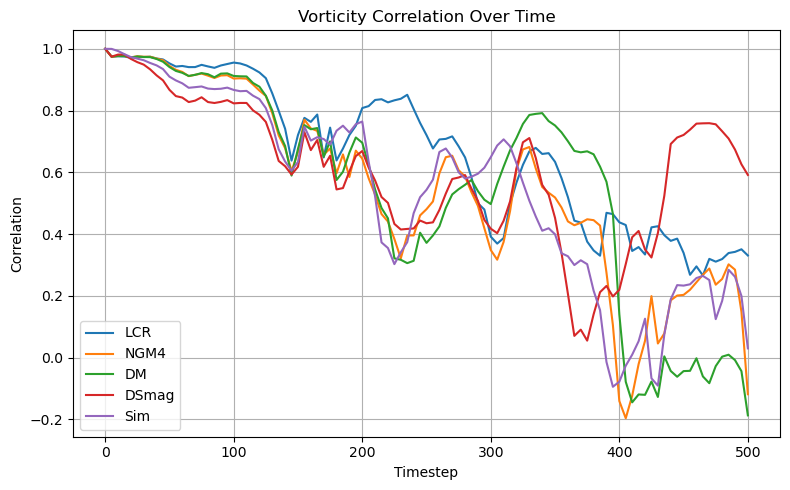

  • saved /storage/home/hcoda1/4/mugliotti3/scratch/Correlations/MatureVM_1e-7/AUX_9_Model_Test.txt
  • saved /storage/home/hcoda1/4/mugliotti3/scratch/Correlations/MatureVM_1e-7/AUX_9_NGM4_Test.txt
  • saved /storage/home/hcoda1/4/mugliotti3/scratch/Correlations/MatureVM_1e-7/AUX_9_DSmag_Test.txt
  • saved /storage/home/hcoda1/4/mugliotti3/scratch/Correlations/MatureVM_1e-7/AUX_9_Sim_Test.txt
  • saved /storage/home/hcoda1/4/mugliotti3/scratch/Correlations/MatureVM_1e-7/AUX_9_DM_Test.txt
[10/12] Computing correlations and saving TXT...


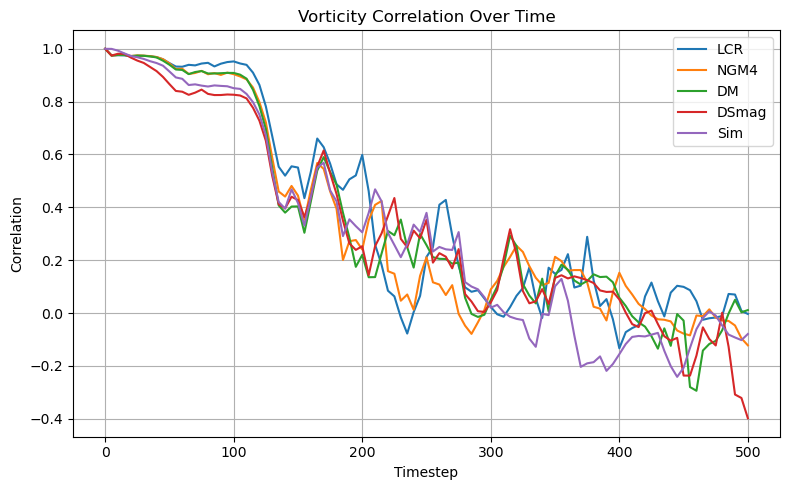

  • saved /storage/home/hcoda1/4/mugliotti3/scratch/Correlations/MatureVM_1e-7/AUX_10_Model_Test.txt
  • saved /storage/home/hcoda1/4/mugliotti3/scratch/Correlations/MatureVM_1e-7/AUX_10_NGM4_Test.txt
  • saved /storage/home/hcoda1/4/mugliotti3/scratch/Correlations/MatureVM_1e-7/AUX_10_DSmag_Test.txt
  • saved /storage/home/hcoda1/4/mugliotti3/scratch/Correlations/MatureVM_1e-7/AUX_10_Sim_Test.txt
  • saved /storage/home/hcoda1/4/mugliotti3/scratch/Correlations/MatureVM_1e-7/AUX_10_DM_Test.txt
[11/12] Computing correlations and saving TXT...


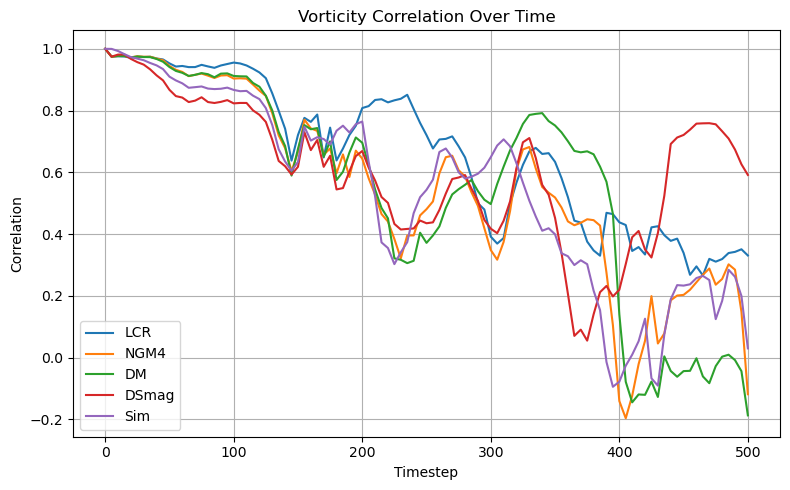

  • saved /storage/home/hcoda1/4/mugliotti3/scratch/Correlations/MatureVM_1e-7/AUX_11_Model_Test.txt
  • saved /storage/home/hcoda1/4/mugliotti3/scratch/Correlations/MatureVM_1e-7/AUX_11_NGM4_Test.txt
  • saved /storage/home/hcoda1/4/mugliotti3/scratch/Correlations/MatureVM_1e-7/AUX_11_DSmag_Test.txt
  • saved /storage/home/hcoda1/4/mugliotti3/scratch/Correlations/MatureVM_1e-7/AUX_11_Sim_Test.txt
  • saved /storage/home/hcoda1/4/mugliotti3/scratch/Correlations/MatureVM_1e-7/AUX_11_DM_Test.txt
[12/12] Computing correlations and saving TXT...


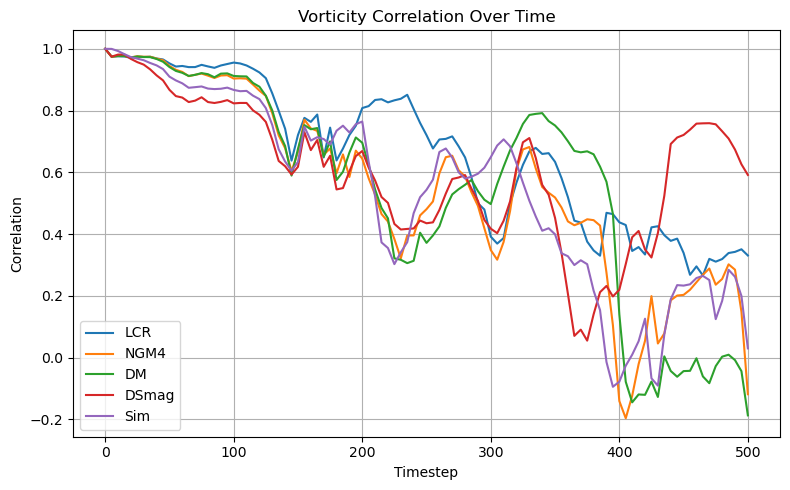

  • saved /storage/home/hcoda1/4/mugliotti3/scratch/Correlations/MatureVM_1e-7/AUX_12_Model_Test.txt
  • saved /storage/home/hcoda1/4/mugliotti3/scratch/Correlations/MatureVM_1e-7/AUX_12_NGM4_Test.txt
  • saved /storage/home/hcoda1/4/mugliotti3/scratch/Correlations/MatureVM_1e-7/AUX_12_DSmag_Test.txt
  • saved /storage/home/hcoda1/4/mugliotti3/scratch/Correlations/MatureVM_1e-7/AUX_12_Sim_Test.txt
  • saved /storage/home/hcoda1/4/mugliotti3/scratch/Correlations/MatureVM_1e-7/AUX_12_DM_Test.txt
Done. All TXT files written.


In [4]:
path = f"/storage/scratch1/1/bchoi73/ENSEMBLE_mature_1e-7"
dt       = 5     
plot     = True 
base_dir = "/storage/home/hcoda1/4/mugliotti3/scratch/Correlations/MatureVM_1e-7"
os.makedirs(base_dir, exist_ok=True)

#Create Labels, also weirdly the DM and DSmag data was saved with the wrong negative sign so we flip it
styles = {
    "Model": "LCR",   # MODELTEST shown as 'LCR'
    "NGM4":  "NGM4",
    "DM":    "DM",
    "DSmag": "DSmag",
    "Sim":   "Sim",
}
sign = {"Model": 1.0, "NGM4": 1.0, "DM": -1.0, "DSmag": -1.0, "Sim": 1.0}

def load_uv(prefix, i):
    arr = load_s(f"{path}/{prefix}_AUX_{i}_e-7.mat")
    V = arr[:, 0, :, :]
    U = arr[:, 1, :, :]
    return U, V

def vorticity_timeseries(U, V, grid): return vmap(lambda u, v: spectral_vorticity(u, v, grid), in_axes=(0, 0))(U, V)

def downsample_timeseries(field, nx, ny): return vmap(lambda f: down_rez(f, nx, ny))(field)

def corr_timeseries(A, B): return vmap(lambda a, b: correlation(a, b))(A, B)

for i in range(1, 13):
    print(f"[{i}/12] Computing correlations and saving TXT...")

    #Load Data
    U_DNS,   V_DNS   = load_uv("DNS",       i)
    U_Model, V_Model = load_uv("MODELTEST", i)
    U_NGM4,  V_NGM4  = load_uv("NGM4",      i)
    U_DM,    V_DM    = load_uv("DM",        i)
    U_DSmag, V_DSmag = load_uv("DSmag",     i)
    U_Sim,   V_Sim   = load_uv("Sim",       i)

    #Calculate Grids
    Nt, Nx_DNS, Ny_DNS = U_DNS.shape
    _,  Nx_LES, Ny_LES = U_Model.shape
    grid_DNS = grids.Grid((Nx_DNS, Ny_DNS), domain=((0, 2*jnp.pi), (0, 2*jnp.pi)))
    grid_LES = grids.Grid((Nx_LES, Ny_LES), domain=((0, 2*jnp.pi), (0, 2*jnp.pi)))

    #Calculate vorticities
    w_DNS   = vorticity_timeseries(U_DNS,   V_DNS,   grid_DNS)
    w_Model = vorticity_timeseries(U_Model, V_Model, grid_LES)
    w_NGM4  = vorticity_timeseries(U_NGM4,  V_NGM4,  grid_LES)
    w_DM    = vorticity_timeseries(U_DM,    V_DM,    grid_LES)
    w_DSmag = vorticity_timeseries(U_DSmag, V_DSmag, grid_LES)
    w_Sim   = vorticity_timeseries(U_Sim,   V_Sim,   grid_LES)

    #Downsample and Filter DNS
    w_DNS_down = downsample_timeseries(w_DNS, Nx_LES, Ny_LES)

    #Compute Correlations
    series = {
        "Model": corr_timeseries(w_DNS_down, w_Model),
        "NGM4":  corr_timeseries(w_DNS_down, w_NGM4),
        "DM":    corr_timeseries(w_DNS_down, w_DM),
        "DSmag": corr_timeseries(w_DNS_down, w_DSmag),
        "Sim":   corr_timeseries(w_DNS_down, w_Sim),
    }

    #Pre-append 1 to time 0 (start)
    for key in series:
        s = sign[key] * series[key]
        series[key] = jnp.concatenate([jnp.array([1.0]), s])

    #Plot for visual inspection
    if plot:
        import matplotlib.pyplot as plt
        t = np.arange(Nt + 1) * dt
        import matplotlib.pyplot as plt
        plt.figure(figsize=(8, 5))
        for key in ["Model", "NGM4", "DM", "DSmag", "Sim"]:
            plt.plot(t, np.asarray(series[key]), label=styles[key])
        plt.xlabel("Timestep")
        plt.ylabel("Correlation")
        plt.title("Vorticity Correlation Over Time")
        plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

    #Save data for later use
    out_map = {
        "Model": f"AUX_{i}_Model_Test",
        "NGM4":  f"AUX_{i}_NGM4_Test",
        "DSmag": f"AUX_{i}_DSmag_Test",
        "Sim":   f"AUX_{i}_Sim_Test",
        "DM":    f"AUX_{i}_DM_Test",
    }
    for key, stem in out_map.items():
        arr = np.asarray(series[key]).reshape(-1)  # ensure 1D
        out_path = os.path.join(base_dir, f"{stem}.txt")
        np.savetxt(out_path, arr, fmt="%.10g")
        print(f"  • saved {out_path}")

    # --- Free memory (optional) ---
    del U_DNS, V_DNS, U_Model, V_Model, U_NGM4, V_NGM4, U_DM, V_DM, U_DSmag, V_DSmag, U_Sim, V_Sim
    del w_DNS, w_Model, w_NGM4, w_DM, w_DSmag, w_Sim, w_DNS_down

print("Done. All TXT files written.")